Running toyexample.data with the standard Gibbs sampler


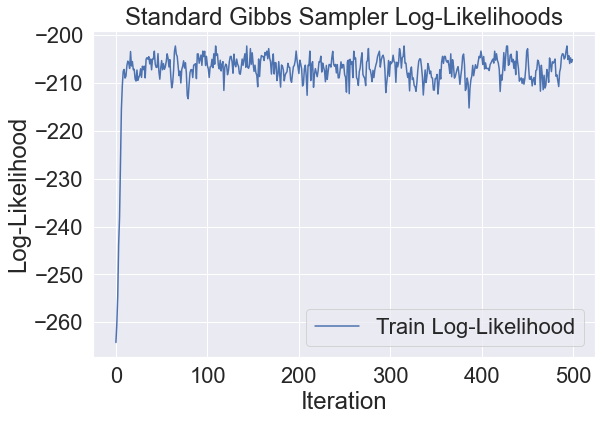

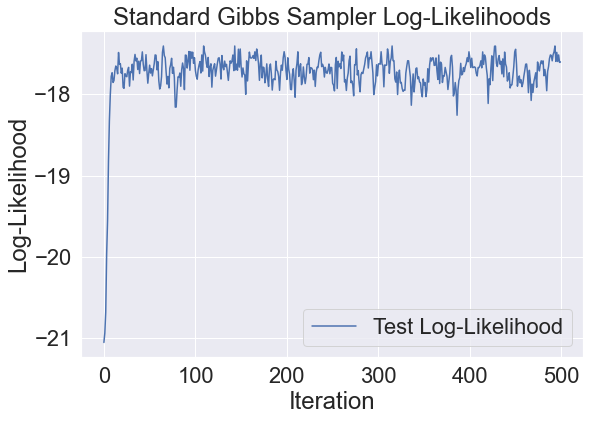

Running toyexample.data with the collapsed Gibbs sampler


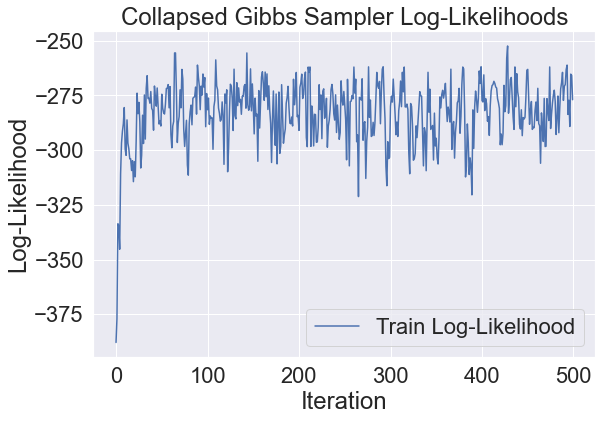

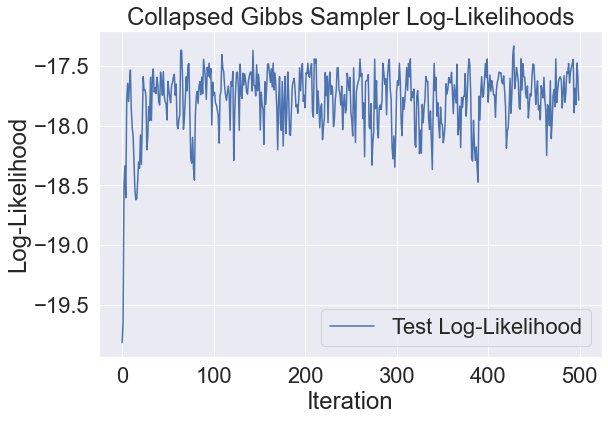

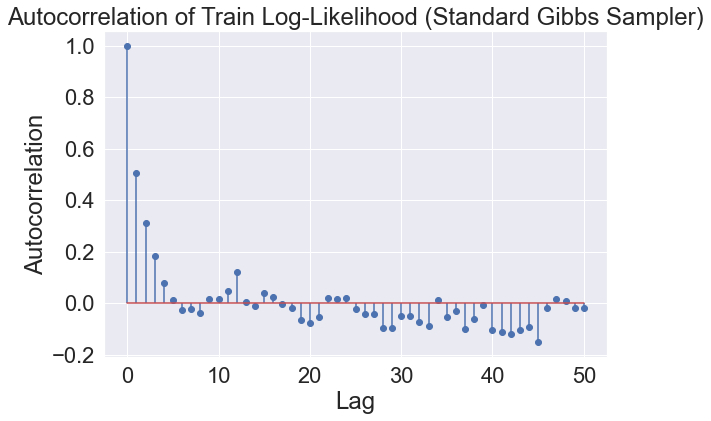

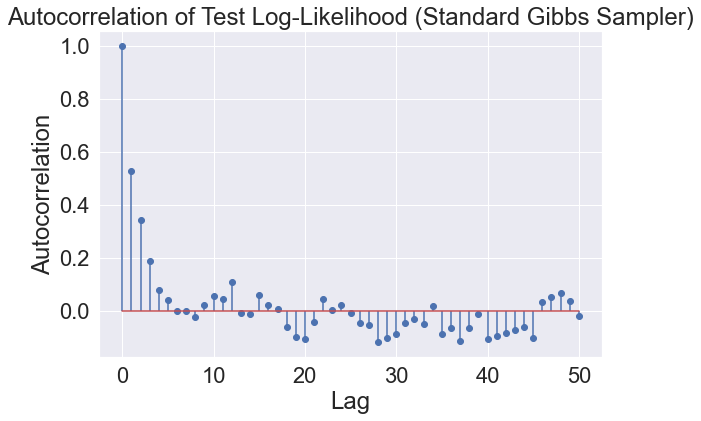

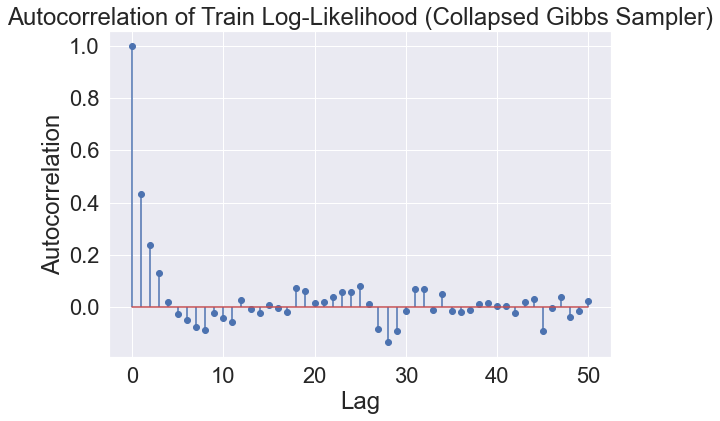

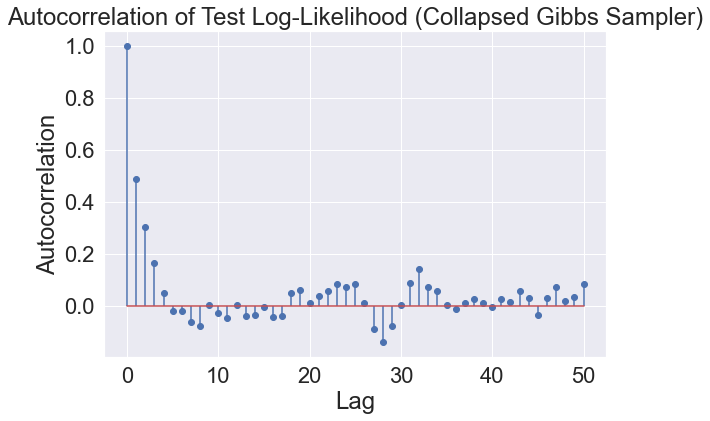

In [20]:
# -*- coding: utf-8 -*-

"""
    File name: gibbs_sampler.py
    Description: A re-implementation of the Gibbs sampler for LDA
    Author: Python: Roman Pogodin, MATLAB (original): Yee Whye Teh and Maneesh Sahani
    Implementation: Yuan Lu (the viusalisation section of the original code is extremely uninformative so I reconstructed most of the code to help it read better and easier to implement the sampler and visuals
    Date created: October 2018
    Python version: 3.6 and above
"""

import numpy as np
import pandas as pd
from scipy.special import gammaln
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf  # For autocorrelation computation
import seaborn as sns
sns.set(font_scale=2)


class GibbsSampler:
    def __init__(self, n_docs, n_topics, n_words, alpha, beta, random_seed=None):
        """
        Standard Gibbs Sampler for LDA.

        :param n_docs:          Number of documents
        :param n_topics:        Number of topics
        :param n_words:         Number of words in vocabulary
        :param alpha:           Dirichlet parameter on topic mixing proportions
        :param beta:            Dirichlet parameter on topic word distributions
        :param random_seed:     Random seed for reproducibility
        """
        self.n_docs = n_docs
        self.n_topics = n_topics
        self.n_words = n_words
        self.alpha = alpha
        self.beta = beta
        self.rand_gen = np.random.RandomState(random_seed)

        # Data placeholders
        self.docs_words = None
        self.docs_words_test = None
        self.do_test = False

        # Count matrices
        self.A_dk = np.zeros((self.n_docs, self.n_topics))  # Document-topic counts
        self.B_kw = np.zeros((self.n_topics, self.n_words))  # Topic-word counts

        # Parameters
        self.theta = np.zeros((self.n_docs, self.n_topics))
        self.phi = np.zeros((self.n_topics, self.n_words))

        # Topic assignments
        self.zi = []

        # Log-likelihoods
        self.loglike = None
        self.loglike_test = None

    def init_sampling(self, docs_words, docs_words_test=None, n_iter=0, save_loglike=False):
        assert np.all(docs_words.shape == (self.n_docs, self.n_words)), "docs_words shape=%s must be (%d, %d)" % (
            docs_words.shape, self.n_docs, self.n_words)
        self.docs_words = docs_words
        self.docs_words_test = docs_words_test

        self.do_test = docs_words_test is not None

        if save_loglike:
            self.loglike = np.zeros(n_iter)
            if self.do_test:
                self.loglike_test = np.zeros(n_iter)

        # Initialize counts
        self.A_dk.fill(0)
        self.B_kw.fill(0)

        # Initialize topic assignments and counts
        self.zi = []
        for d in range(self.n_docs):
            doc_topics = []
            for w in range(self.n_words):
                count = int(self.docs_words[d, w])
                if count > 0:
                    topics = self.rand_gen.randint(0, self.n_topics, size=count)
                    doc_topics.append(topics)
                    # Update counts
                    for k in topics:
                        self.A_dk[d, k] += 1
                        self.B_kw[k, w] += 1
                else:
                    doc_topics.append(np.array([], dtype=int))
            self.zi.append(doc_topics)

        # Initialize theta and phi
        self.update_theta_phi()

    def run(self, docs_words, docs_words_test=None, n_iter=100, save_loglike=False):
        self.init_sampling(docs_words, docs_words_test, n_iter=n_iter, save_loglike=save_loglike)

        for iteration in range(n_iter):
            self.update_params()
            if save_loglike:
                self.update_loglike(iteration)

        return self.theta, self.phi

    def update_params(self):
        # Sample topic assignments
        for d in range(self.n_docs):
            for w in range(self.n_words):
                topics = self.zi[d][w]
                for n in range(len(topics)):
                    k = topics[n]
                    # Decrement counts
                    self.A_dk[d, k] -= 1
                    self.B_kw[k, w] -= 1

                    # Compute conditional distribution
                    p_z = self.theta[d, :] * self.phi[:, w]
                    p_z /= np.sum(p_z)

                    # Sample new topic
                    new_k = self.rand_gen.choice(self.n_topics, p=p_z)
                    topics[n] = new_k

                    # Increment counts
                    self.A_dk[d, new_k] += 1
                    self.B_kw[new_k, w] += 1

        # Sample theta and phi
        self.update_theta_phi()

    def update_theta_phi(self):
        # Sample theta from Dirichlet distribution
        self.theta = self.A_dk + self.alpha
        self.theta /= np.sum(self.theta, axis=1, keepdims=True)

        # Sample phi from Dirichlet distribution
        self.phi = self.B_kw + self.beta
        self.phi /= np.sum(self.phi, axis=1, keepdims=True)

    def update_loglike(self, iteration):
        # Compute log-likelihood for training data
        ll = np.sum((self.alpha - 1) * np.log(self.theta))
        ll += np.sum((self.beta - 1) * np.log(self.phi))
        for d in range(self.n_docs):
            for w in range(self.n_words):
                count = self.docs_words[d, w]
                if count > 0:
                    prob = np.dot(self.theta[d, :], self.phi[:, w])
                    ll += count * np.log(prob + 1e-12)
        self.loglike[iteration] = ll

        if self.do_test:
            # Compute log-likelihood for test data
            ll_test = 0
            for d in range(self.n_docs):
                for w in range(self.n_words):
                    count = self.docs_words_test[d, w]
                    if count > 0:
                        prob = np.dot(self.theta[d, :], self.phi[:, w])
                        ll_test += count * np.log(prob + 1e-12)
            self.loglike_test[iteration] = ll_test

    def get_loglike(self):
        if self.do_test:
            return self.loglike, self.loglike_test
        else:
            return self.loglike


class GibbsSamplerCollapsed:
    def __init__(self, n_docs, n_topics, n_words, alpha, beta, random_seed=None):
        """
        Collapsed Gibbs Sampler for LDA.

        :param n_docs:          Number of documents
        :param n_topics:        Number of topics
        :param n_words:         Number of words in vocabulary
        :param alpha:           Dirichlet parameter on topic mixing proportions
        :param beta:            Dirichlet parameter on topic word distributions
        :param random_seed:     Random seed for reproducibility
        """
        self.n_docs = n_docs
        self.n_topics = n_topics
        self.n_words = n_words
        self.alpha = alpha
        self.beta = beta
        self.rand_gen = np.random.RandomState(random_seed)

        # Data placeholders
        self.docs_words = None
        self.docs_words_test = None
        self.do_test = False

        # Count matrices
        self.A_dk = np.zeros((self.n_docs, self.n_topics))  # Document-topic counts
        self.B_kw = np.zeros((self.n_topics, self.n_words))  # Topic-word counts

        # Topic assignments
        self.zi = []

        # Log-likelihoods
        self.loglike = None
        self.loglike_test = None

    def init_sampling(self, docs_words, docs_words_test=None, n_iter=0, save_loglike=False):
        assert np.all(docs_words.shape == (self.n_docs, self.n_words)), "docs_words shape=%s must be (%d, %d)" % (
            docs_words.shape, self.n_docs, self.n_words)
        self.docs_words = docs_words
        self.docs_words_test = docs_words_test

        self.do_test = docs_words_test is not None

        if save_loglike:
            self.loglike = np.zeros(n_iter)
            if self.do_test:
                self.loglike_test = np.zeros(n_iter)

        # Initialize counts
        self.A_dk.fill(0)
        self.B_kw.fill(0)

        # Initialize topic assignments
        self.zi = []
        for d in range(self.n_docs):
            doc_topics = []
            for w in range(self.n_words):
                count = int(self.docs_words[d, w])
                if count > 0:
                    topics = self.rand_gen.randint(0, self.n_topics, size=count)
                    doc_topics.append(topics)
                    # Update counts
                    for k in topics:
                        self.A_dk[d, k] += 1
                        self.B_kw[k, w] += 1
                else:
                    doc_topics.append(np.array([], dtype=int))
            self.zi.append(doc_topics)

    def run(self, docs_words, docs_words_test=None, n_iter=100, save_loglike=False):
        self.init_sampling(docs_words, docs_words_test, n_iter=n_iter, save_loglike=save_loglike)

        for iteration in range(n_iter):
            self.update_params()
            if save_loglike:
                self.update_loglike(iteration)

        return self.A_dk, self.B_kw

    def update_params(self):
        # Sample topic assignments
        for d in range(self.n_docs):
            for w in range(self.n_words):
                topics = self.zi[d][w]
                for n in range(len(topics)):
                    k = topics[n]
                    # Decrement counts
                    self.A_dk[d, k] -= 1
                    self.B_kw[k, w] -= 1

                    # Compute conditional distribution (collapsed)
                    p_z = (self.A_dk[d, :] + self.alpha) * (self.B_kw[:, w] + self.beta)
                    denom = (np.sum(self.B_kw, axis=1) + self.n_words * self.beta)
                    p_z /= denom
                    p_z /= np.sum(p_z)

                    # Sample new topic
                    new_k = self.rand_gen.choice(self.n_topics, p=p_z)
                    topics[n] = new_k

                    # Increment counts
                    self.A_dk[d, new_k] += 1
                    self.B_kw[new_k, w] += 1

    def update_loglike(self, iteration):
        # Compute joint log-likelihood (excluding constants)
        ll = 0
        # Document-topic distributions
        ll += np.sum(gammaln(self.A_dk + self.alpha) - gammaln(self.alpha))
        ll -= np.sum(gammaln(np.sum(self.A_dk + self.alpha, axis=1)) - gammaln(self.n_topics * self.alpha))
        # Topic-word distributions
        ll += np.sum(gammaln(self.B_kw + self.beta) - gammaln(self.beta))
        ll -= np.sum(gammaln(np.sum(self.B_kw + self.beta, axis=1)) - gammaln(self.n_words * self.beta))
        self.loglike[iteration] = ll

        if self.do_test:
            # Compute predictive log-likelihood for test data
            phi = (self.B_kw + self.beta)
            phi /= np.sum(phi, axis=1)[:, np.newaxis]

            theta_test = (self.A_dk + self.alpha)
            theta_test /= np.sum(theta_test, axis=1)[:, np.newaxis]

            ll_test = 0
            for d in range(self.n_docs):
                for w in range(self.n_words):
                    count = self.docs_words_test[d, w]
                    if count > 0:
                        prob = np.dot(theta_test[d, :], phi[:, w])
                        ll_test += count * np.log(prob + 1e-12)  # Avoid log(0)
            self.loglike_test[iteration] = ll_test

    def get_loglike(self):
        if self.do_test:
            return self.loglike, self.loglike_test
        else:
            return self.loglike


def read_data(filename):
    """
    Reads the text data and splits into train/test.
    """
    data = pd.read_csv(filename, dtype=int, sep=' ', names=['doc', 'word', 'train', 'test'])

    n_docs = np.amax(data.loc[:, 'doc'])
    n_words = np.amax(data.loc[:, 'word'])

    docs_words_train = np.zeros((n_docs, n_words), dtype=int)
    docs_words_test = np.zeros((n_docs, n_words), dtype=int)

    docs_words_train[data.loc[:, 'doc'] - 1, data.loc[:, 'word'] - 1] = data.loc[:, 'train']
    docs_words_test[data.loc[:, 'doc'] - 1, data.loc[:, 'word'] - 1] = data.loc[:, 'test']

    return docs_words_train, docs_words_test


def main():
    print('Running toyexample.data with the standard Gibbs sampler')

    # Read data
    docs_words_train, docs_words_test = read_data('toyexample.data')
    n_docs, n_words = docs_words_train.shape
    n_topics = 3
    alpha = 1.0
    beta = 1.0
    random_seed = 0
    n_iter = 500  # Increased iterations for stability

    # Standard Gibbs Sampler
    sampler = GibbsSampler(n_docs=n_docs, n_topics=n_topics, n_words=n_words,
                           alpha=alpha, beta=beta, random_seed=random_seed)

    theta, phi = sampler.run(docs_words_train, docs_words_test, n_iter=n_iter, save_loglike=True)

    like_train, like_test = sampler.get_loglike()

    # Plot log-likelihoods
    plt.figure(figsize=(9, 6))
    plt.plot(like_train, label='Train Log-Likelihood')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('Standard Gibbs Sampler Log-Likelihoods')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(9, 6))
    plt.plot(like_test, label='Test Log-Likelihood')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('Standard Gibbs Sampler Log-Likelihoods')
    plt.legend()
    plt.show()

    print('Running toyexample.data with the collapsed Gibbs sampler')

    # Collapsed Gibbs Sampler
    sampler_collapsed = GibbsSamplerCollapsed(n_docs=n_docs, n_topics=n_topics, n_words=n_words,
                                              alpha=alpha, beta=beta, random_seed=random_seed)

    sampler_collapsed.run(docs_words_train, docs_words_test, n_iter=n_iter, save_loglike=True)

    like_train_collapsed, like_test_collapsed = sampler_collapsed.get_loglike()

    # Plot log-likelihoods
    plt.figure(figsize=(9, 6))
    plt.plot(like_train_collapsed, label='Train Log-Likelihood')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('Collapsed Gibbs Sampler Log-Likelihoods')
    plt.legend()
    plt.show()

    plt.figure(figsize=(9, 6))
    plt.plot(like_test_collapsed, label='Test Log-Likelihood')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('Collapsed Gibbs Sampler Log-Likelihoods')
    plt.legend()
    plt.show()


    # Compute and plot autocorrelations (after burn-in)
    burn_in = 200
    plot_autocorrelation(like_train[burn_in:], 'Autocorrelation of Train Log-Likelihood (Standard Gibbs Sampler)')
    plot_autocorrelation(like_test[burn_in:], 'Autocorrelation of Test Log-Likelihood (Standard Gibbs Sampler)')

    plot_autocorrelation(like_train_collapsed[burn_in:], 'Autocorrelation of Train Log-Likelihood (Collapsed Gibbs Sampler)')
    plot_autocorrelation(like_test_collapsed[burn_in:], 'Autocorrelation of Test Log-Likelihood (Collapsed Gibbs Sampler)')


def plot_autocorrelation(log_values, title):
    """
    Computes and plots the autocorrelation of a time series.
    """
    autocorr = acf(log_values, nlags=50, fft=False)
    plt.figure(figsize=(9, 6))
    plt.stem(range(len(autocorr)), autocorr, linefmt='b-', markerfmt='bo', basefmt='r-')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title)
    plt.show()


if __name__ == '__main__':
    main()


Running toyexample.data with the standard Gibbs sampler


Gibbs Sampling: 100%|██████████| 200/200 [00:01<00:00, 199.08iter/s]


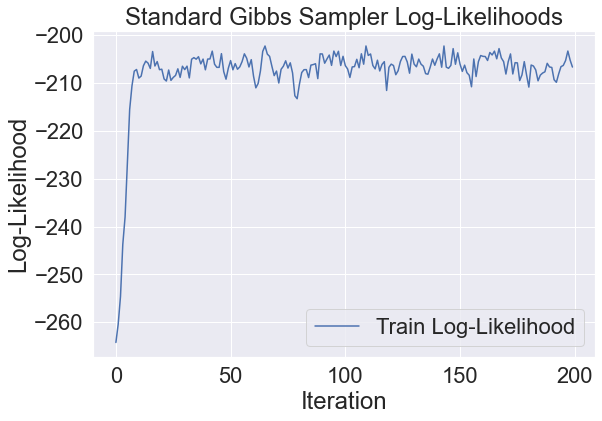

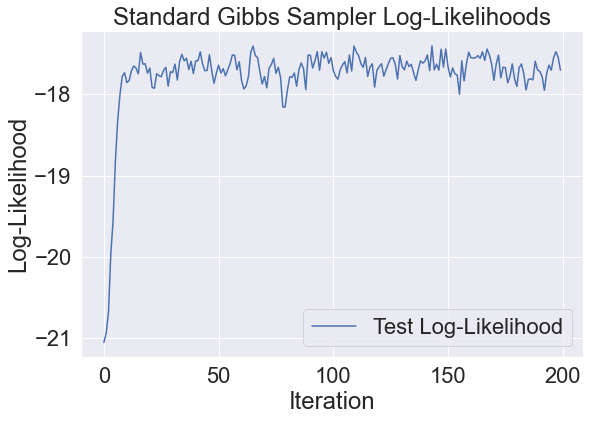

Running toyexample.data with the collapsed Gibbs sampler


Collapsed Gibbs Sampling: 100%|██████████| 200/200 [00:01<00:00, 142.14iter/s]


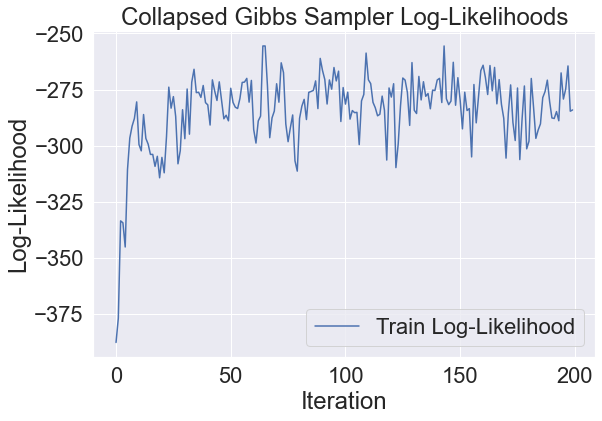

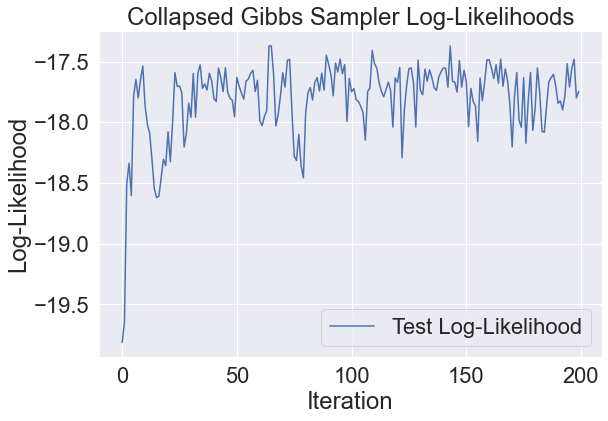

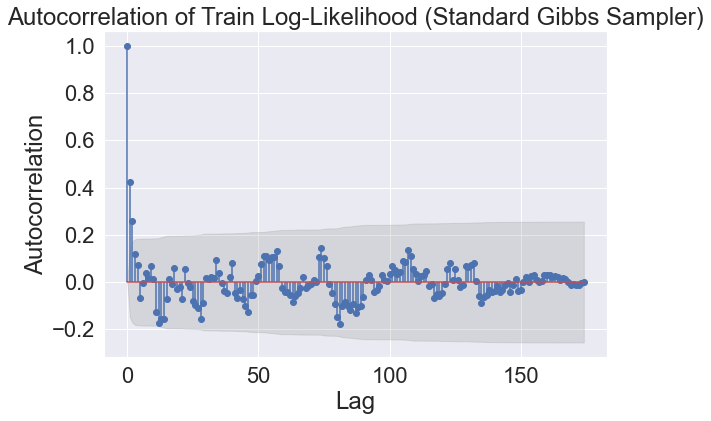

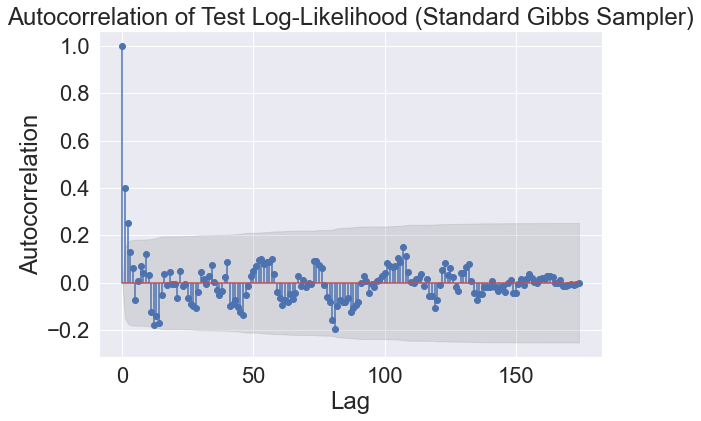

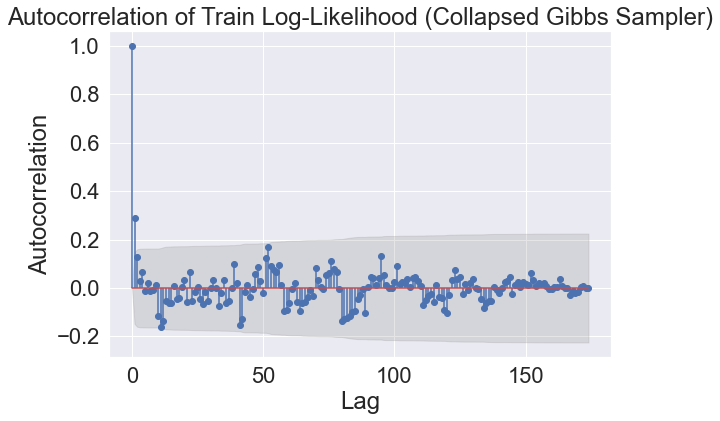

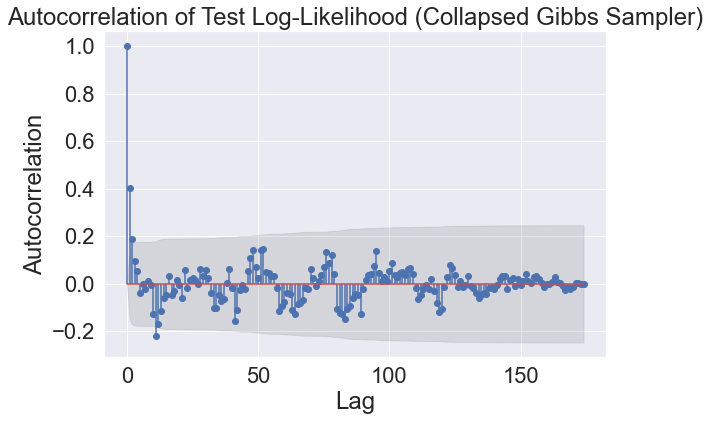

In [36]:
# -*- coding: utf-8 -*-

"""
    File name: gibbs_sampler.py
    Description: A re-implementation of the Gibbs sampler for LDA
    Author: Python: Roman Pogodin, MATLAB (original): Yee Whye Teh and Maneesh Sahani
    Implementation: Yuan Lu
    Date created: October 2018
    Python version: 3.6 and above
"""

import numpy as np
import pandas as pd
from scipy.special import gammaln
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf  # For autocorrelation computation
import seaborn as sns
from tqdm import tqdm  # Import tqdm for progress bars this is useful for nips modelling
sns.set(font_scale=2)


class GibbsSampler:
    def __init__(self, n_docs, n_topics, n_words, alpha, beta, random_seed=None):
        """
        Standard Gibbs Sampler for LDA.

        :param n_docs:          Number of documents
        :param n_topics:        Number of topics
        :param n_words:         Number of words in vocabulary
        :param alpha:           Dirichlet parameter on topic mixing proportions
        :param beta:            Dirichlet parameter on topic word distributions
        :param random_seed:     Random seed for reproducibility
        """
        self.n_docs = n_docs
        self.n_topics = n_topics
        self.n_words = n_words
        self.alpha = alpha
        self.beta = beta
        self.rand_gen = np.random.RandomState(random_seed)

        # Data placeholders
        self.docs_words = None
        self.docs_words_test = None
        self.do_test = False

        # Count matrices
        self.A_dk = np.zeros((self.n_docs, self.n_topics))  # Document-topic counts
        self.B_kw = np.zeros((self.n_topics, self.n_words))  # Topic-word counts

        # Parameters
        self.theta = np.zeros((self.n_docs, self.n_topics))
        self.phi = np.zeros((self.n_topics, self.n_words))

        # Topic assignments
        self.zi = []

        # Log-likelihoods
        self.loglike = None
        self.loglike_test = None

    def init_sampling(self, docs_words, docs_words_test=None, n_iter=0, save_loglike=False):
        assert np.all(docs_words.shape == (self.n_docs, self.n_words)), "docs_words shape=%s must be (%d, %d)" % (
            docs_words.shape, self.n_docs, self.n_words)
        self.docs_words = docs_words
        self.docs_words_test = docs_words_test

        self.do_test = docs_words_test is not None

        if save_loglike:
            self.loglike = np.zeros(n_iter)
            if self.do_test:
                self.loglike_test = np.zeros(n_iter)

        # Initialize counts
        self.A_dk.fill(0)
        self.B_kw.fill(0)

        # Initialize topic assignments and counts
        self.zi = []
        for d in range(self.n_docs):
            doc_topics = []
            for w in range(self.n_words):
                count = int(self.docs_words[d, w])
                if count > 0:
                    topics = self.rand_gen.randint(0, self.n_topics, size=count)
                    doc_topics.append(topics)
                    # Update counts
                    for k in topics:
                        self.A_dk[d, k] += 1
                        self.B_kw[k, w] += 1
                else:
                    doc_topics.append(np.array([], dtype=int))
            self.zi.append(doc_topics)

        # Initialize theta and phi
        self.update_theta_phi()

    def run(self, docs_words, docs_words_test=None, n_iter=100, save_loglike=False):
        self.init_sampling(docs_words, docs_words_test, n_iter=n_iter, save_loglike=save_loglike)

        for iteration in tqdm(range(n_iter), desc="Gibbs Sampling", unit="iter"):
            self.update_params()
            if save_loglike:
                self.update_loglike(iteration)

        return self.theta, self.phi

    def update_params(self):
        # Sample topic assignments
        for d in range(self.n_docs):
            for w in range(self.n_words):
                topics = self.zi[d][w]
                for n in range(len(topics)):
                    k = topics[n]
                    # Decrement counts
                    self.A_dk[d, k] -= 1
                    self.B_kw[k, w] -= 1

                    # Compute conditional distribution
                    p_z = self.theta[d, :] * self.phi[:, w]
                    p_z /= np.sum(p_z)

                    # Sample new topic
                    new_k = self.rand_gen.choice(self.n_topics, p=p_z)
                    topics[n] = new_k

                    # Increment counts
                    self.A_dk[d, new_k] += 1
                    self.B_kw[new_k, w] += 1

        # Sample theta and phi
        self.update_theta_phi()

    def update_theta_phi(self):
        # Sample theta from Dirichlet distribution
        self.theta = self.A_dk + self.alpha
        self.theta /= np.sum(self.theta, axis=1, keepdims=True)

        # Sample phi from Dirichlet distribution
        self.phi = self.B_kw + self.beta
        self.phi /= np.sum(self.phi, axis=1, keepdims=True)

    def update_loglike(self, iteration):
        # Compute log-likelihood for training data
        ll = np.sum((self.alpha - 1) * np.log(self.theta))
        ll += np.sum((self.beta - 1) * np.log(self.phi))
        for d in range(self.n_docs):
            for w in range(self.n_words):
                count = self.docs_words[d, w]
                if count > 0:
                    prob = np.dot(self.theta[d, :], self.phi[:, w])
                    ll += count * np.log(prob + 1e-12)
        self.loglike[iteration] = ll

        if self.do_test:
            # Compute log-likelihood for test data
            ll_test = 0
            for d in range(self.n_docs):
                for w in range(self.n_words):
                    count = self.docs_words_test[d, w]
                    if count > 0:
                        prob = np.dot(self.theta[d, :], self.phi[:, w])
                        ll_test += count * np.log(prob + 1e-12)
            self.loglike_test[iteration] = ll_test

    def get_loglike(self):
        if self.do_test:
            return self.loglike, self.loglike_test
        else:
            return self.loglike


class GibbsSamplerCollapsed:
    def __init__(self, n_docs, n_topics, n_words, alpha, beta, random_seed=None):
        """
        Collapsed Gibbs Sampler for LDA.

        :param n_docs:          Number of documents
        :param n_topics:        Number of topics
        :param n_words:         Number of words in vocabulary
        :param alpha:           Dirichlet parameter on topic mixing proportions
        :param beta:            Dirichlet parameter on topic word distributions
        :param random_seed:     Random seed for reproducibility
        """
        self.n_docs = n_docs
        self.n_topics = n_topics
        self.n_words = n_words
        self.alpha = alpha
        self.beta = beta
        self.rand_gen = np.random.RandomState(random_seed)

        # Data placeholders
        self.docs_words = None
        self.docs_words_test = None
        self.do_test = False

        # Count matrices
        self.A_dk = np.zeros((self.n_docs, self.n_topics))  # Document-topic counts
        self.B_kw = np.zeros((self.n_topics, self.n_words))  # Topic-word counts

        # Topic assignments
        self.zi = []

        # Log-likelihoods
        self.loglike = None
        self.loglike_test = None

    def init_sampling(self, docs_words, docs_words_test=None, n_iter=0, save_loglike=False):
        assert np.all(docs_words.shape == (self.n_docs, self.n_words)), "docs_words shape=%s must be (%d, %d)" % (
            docs_words.shape, self.n_docs, self.n_words)
        self.docs_words = docs_words
        self.docs_words_test = docs_words_test

        self.do_test = docs_words_test is not None

        if save_loglike:
            self.loglike = np.zeros(n_iter)
            if self.do_test:
                self.loglike_test = np.zeros(n_iter)

        # Initialize counts
        self.A_dk.fill(0)
        self.B_kw.fill(0)

        # Initialize topic assignments
        self.zi = []
        for d in range(self.n_docs):
            doc_topics = []
            for w in range(self.n_words):
                count = int(self.docs_words[d, w])
                if count > 0:
                    topics = self.rand_gen.randint(0, self.n_topics, size=count)
                    doc_topics.append(topics)
                    # Update counts
                    for k in topics:
                        self.A_dk[d, k] += 1
                        self.B_kw[k, w] += 1
                else:
                    doc_topics.append(np.array([], dtype=int))
            self.zi.append(doc_topics)

    def run(self, docs_words, docs_words_test=None, n_iter=100, save_loglike=False):
        self.init_sampling(docs_words, docs_words_test, n_iter=n_iter, save_loglike=save_loglike)

        for iteration in tqdm(range(n_iter), desc="Collapsed Gibbs Sampling", unit="iter"):
            self.update_params()
            if save_loglike:
                self.update_loglike(iteration)

        return self.A_dk, self.B_kw

    def update_params(self):
        # Sample topic assignments
        for d in range(self.n_docs):
            for w in range(self.n_words):
                topics = self.zi[d][w]
                for n in range(len(topics)):
                    k = topics[n]
                    # Decrement counts
                    self.A_dk[d, k] -= 1
                    self.B_kw[k, w] -= 1

                    # Compute conditional distribution (collapsed)
                    p_z = (self.A_dk[d, :] + self.alpha) * (self.B_kw[:, w] + self.beta)
                    denom = (np.sum(self.B_kw, axis=1) + self.n_words * self.beta)
                    p_z /= denom
                    p_z /= np.sum(p_z)

                    # Sample new topic
                    new_k = self.rand_gen.choice(self.n_topics, p=p_z)
                    topics[n] = new_k

                    # Increment counts
                    self.A_dk[d, new_k] += 1
                    self.B_kw[new_k, w] += 1

    def update_loglike(self, iteration):
        # Compute joint log-likelihood (excluding constants)
        ll = 0
        # Document-topic distributions
        ll += np.sum(gammaln(self.A_dk + self.alpha) - gammaln(self.alpha))
        ll += np.sum(gammaln(self.n_topics * self.alpha) - gammaln(np.sum(self.A_dk + self.alpha, axis=1)))

        # Topic-word distributions
        ll += np.sum(gammaln(self.B_kw + self.beta) - gammaln(self.beta))
        ll += np.sum(gammaln(self.n_words * self.beta) - gammaln(np.sum(self.B_kw + self.beta, axis=1)))

        self.loglike[iteration] = ll

        if self.do_test:
            # Compute predictive log-likelihood for test data
            phi = (self.B_kw + self.beta)
            phi /= np.sum(phi, axis=1, keepdims=True)

            theta_test = (self.A_dk + self.alpha)
            theta_test /= np.sum(theta_test, axis=1, keepdims=True)

            ll_test = 0
            for d in range(self.n_docs):
                for w in range(self.n_words):
                    count = self.docs_words_test[d, w]
                    if count > 0:
                        prob = np.dot(theta_test[d, :], phi[:, w])
                        ll_test += count * np.log(prob + 1e-12)  # Avoid log(0)
            self.loglike_test[iteration] = ll_test

    def get_loglike(self):
        if self.do_test:
            return self.loglike, self.loglike_test
        else:
            return self.loglike


def read_data(filename):
    """
    Reads the text data and splits into train/test.
    """
    data = pd.read_csv(filename, dtype=int, sep=' ', names=['doc', 'word', 'train', 'test'])

    n_docs = np.amax(data.loc[:, 'doc'])
    n_words = np.amax(data.loc[:, 'word'])

    docs_words_train = np.zeros((n_docs, n_words), dtype=int)
    docs_words_test = np.zeros((n_docs, n_words), dtype=int)

    docs_words_train[data.loc[:, 'doc'] - 1, data.loc[:, 'word'] - 1] = data.loc[:, 'train']
    docs_words_test[data.loc[:, 'doc'] - 1, data.loc[:, 'word'] - 1] = data.loc[:, 'test']

    return docs_words_train, docs_words_test


def main():
    print('Running toyexample.data with the standard Gibbs sampler')

    # Read data
    docs_words_train, docs_words_test = read_data('toyexample.data')
    n_docs, n_words = docs_words_train.shape
    n_topics = 3
    alpha = 1
    beta = 1
    random_seed = 0
    n_iter = 200

    # Standard Gibbs Sampler
    sampler = GibbsSampler(n_docs=n_docs, n_topics=n_topics, n_words=n_words,
                           alpha=alpha, beta=beta, random_seed=random_seed)

    theta, phi = sampler.run(docs_words_train, docs_words_test, n_iter=n_iter, save_loglike=True)

    like_train, like_test = sampler.get_loglike()

    # Plot log-likelihoods
    plt.figure(figsize=(9, 6))
    plt.plot(like_train, label='Train Log-Likelihood')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('Standard Gibbs Sampler Log-Likelihoods')
    plt.legend()
    plt.savefig('std_gibbs_train.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(9, 6))
    plt.plot(like_test, label='Test Log-Likelihood')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('Standard Gibbs Sampler Log-Likelihoods')
    plt.legend()
    plt.savefig('std_gibbs_test.png', dpi=300)
    plt.show()

    print('Running toyexample.data with the collapsed Gibbs sampler')

    # Collapsed Gibbs Sampler
    sampler_collapsed = GibbsSamplerCollapsed(n_docs=n_docs, n_topics=n_topics, n_words=n_words,
                                              alpha=alpha, beta=beta, random_seed=random_seed)

    sampler_collapsed.run(docs_words_train, docs_words_test, n_iter=n_iter, save_loglike=True)

    like_train_collapsed, like_test_collapsed = sampler_collapsed.get_loglike()

    # Plot log-likelihoods
    plt.figure(figsize=(9, 6))
    plt.plot(like_train_collapsed, label='Train Log-Likelihood')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('Collapsed Gibbs Sampler Log-Likelihoods')
    plt.legend()
    plt.savefig('col_gibbs_train.png', dpi=300)
    plt.show()

    plt.figure(figsize=(9, 6))
    plt.plot(like_test_collapsed, label='Test Log-Likelihood')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('Collapsed Gibbs Sampler Log-Likelihoods')
    plt.legend()
    plt.savefig('col_gibbs_test.png', dpi=300)
    plt.show()


    # Compute and plot autocorrelations (after burn-in)
    burn_in = 25
    plot_autocorrelation(like_train[burn_in:], 'Autocorrelation of Train Log-Likelihood (Standard Gibbs Sampler)')
    plot_autocorrelation(like_test[burn_in:], 'Autocorrelation of Test Log-Likelihood (Standard Gibbs Sampler)')

    plot_autocorrelation(like_train_collapsed[burn_in:], 'Autocorrelation of Train Log-Likelihood (Collapsed Gibbs Sampler)')
    plot_autocorrelation(like_test_collapsed[burn_in:], 'Autocorrelation of Test Log-Likelihood (Collapsed Gibbs Sampler)')


def plot_autocorrelation(log_values, title):
    """
    Computes and plots the autocorrelation of a time series with confidence bounds.
    """
    # Calculate autocorrelation and confidence intervals
    autocorr, confint = acf(log_values, nlags=500, alpha=0.05, fft=False)
    lags = range(len(autocorr))

    # Create the plot
    plt.figure(figsize=(9, 6))
    plt.stem(lags, autocorr, linefmt='b-', markerfmt='bo', basefmt='r-')

    # Add confidence bound
    confint_minus_mean = confint - autocorr[:, None]
    plt.fill_between(lags, confint_minus_mean[:, 0], confint_minus_mean[:, 1], color='gray', alpha=0.2)

    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title)
    plt.savefig(f'{title}.png', dpi=300)
    plt.show()


if __name__ == '__main__':
    main()


Experimenting with varying α, β, and n_topics

Varying α while fixing β and n_topics
Running with α=0.1, β=1.0, n_topics=3


Gibbs Sampling: 100%|██████████| 200/200 [00:01<00:00, 193.61iter/s]


Running with α=1.0, β=1.0, n_topics=3


Gibbs Sampling: 100%|██████████| 200/200 [00:00<00:00, 200.90iter/s]


Running with α=5.0, β=1.0, n_topics=3


Gibbs Sampling: 100%|██████████| 200/200 [00:00<00:00, 202.85iter/s]


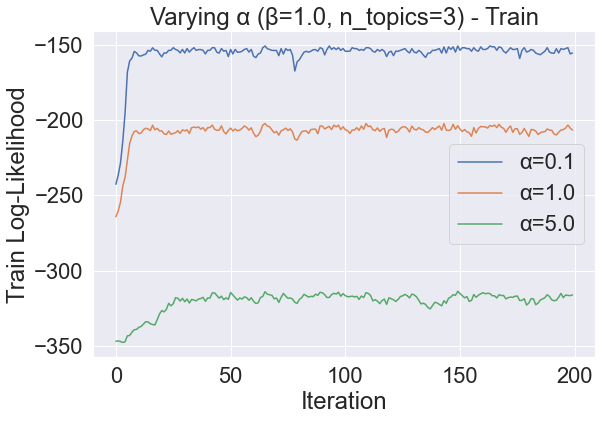

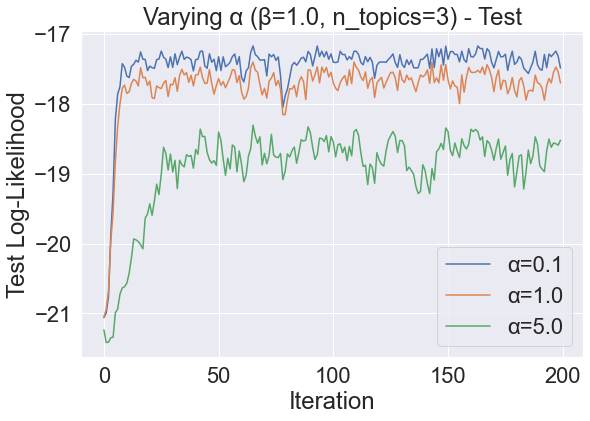


Varying β while fixing α and n_topics
Running with α=1.0, β=0.1, n_topics=3


Gibbs Sampling: 100%|██████████| 200/200 [00:01<00:00, 191.61iter/s]


Running with α=1.0, β=1.0, n_topics=3


Gibbs Sampling: 100%|██████████| 200/200 [00:01<00:00, 192.30iter/s]


Running with α=1.0, β=5.0, n_topics=3


Gibbs Sampling: 100%|██████████| 200/200 [00:01<00:00, 188.12iter/s]


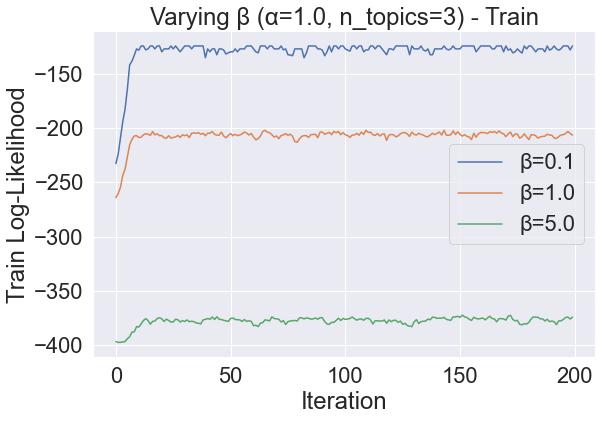

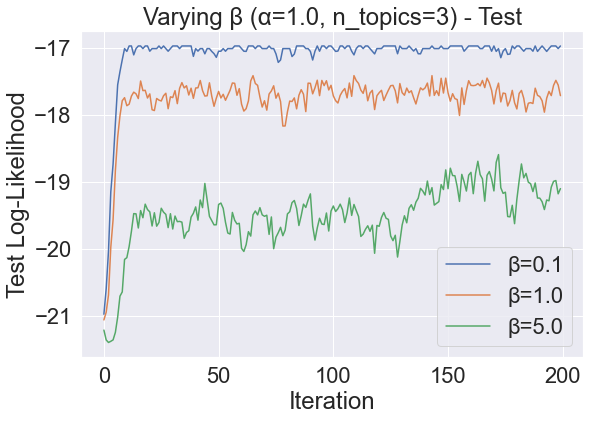


Varying n_topics while fixing α and β
Running with α=1.0, β=1.0, n_topics=2


Gibbs Sampling: 100%|██████████| 200/200 [00:01<00:00, 185.98iter/s]


Running with α=1.0, β=1.0, n_topics=3


Gibbs Sampling: 100%|██████████| 200/200 [00:01<00:00, 191.92iter/s]


Running with α=1.0, β=1.0, n_topics=5


Gibbs Sampling: 100%|██████████| 200/200 [00:01<00:00, 194.39iter/s]


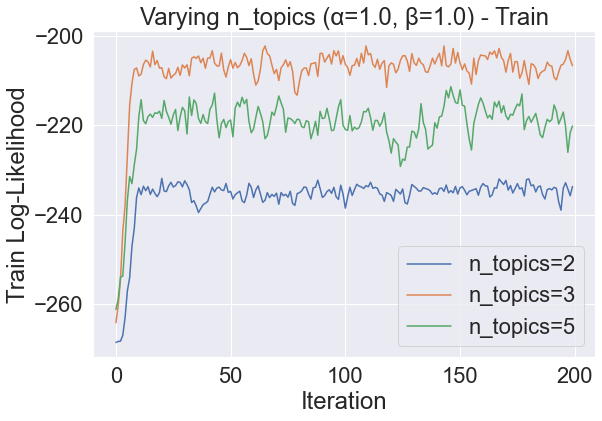

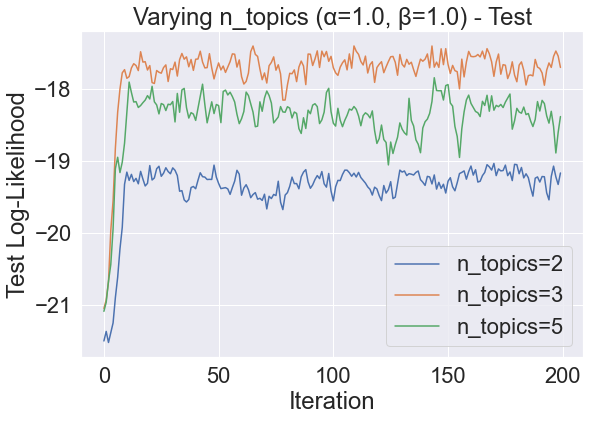


Summary of Results:
   alpha  beta  n_topics  train_loglike  test_loglike
0    0.1   1.0         3    -155.373095    -17.490876
1    1.0   1.0         3    -206.637482    -17.704448
2    5.0   1.0         3    -316.220952    -18.524225
3    1.0   0.1         3    -124.621520    -16.963156
4    1.0   1.0         3    -206.637482    -17.704448
5    1.0   5.0         3    -374.145522    -19.092701
6    1.0   1.0         2    -233.713015    -19.171277
7    1.0   1.0         3    -206.637482    -17.704448
8    1.0   1.0         5    -220.157775    -18.387056


In [38]:
def main():
    print('Experimenting with varying α, β, and n_topics')

    # Read data
    docs_words_train, docs_words_test = read_data('toyexample.data')
    n_docs, n_words = docs_words_train.shape
    random_seed = 0
    n_iter = 200

    # Define parameter ranges
    alpha_values = [0.1, 1.0, 5.0]
    beta_values = [0.1, 1.0, 5.0]
    n_topics_values = [2, 3, 5]

    # Fixed parameters
    fixed_beta = 1.0
    fixed_n_topics = 3
    fixed_alpha = 1.0

    # Store results
    results = []

    # Vary alpha while fixing beta and n_topics
    print('\nVarying α while fixing β and n_topics')

    # Dictionaries to store log-likelihoods
    loglike_train_alpha = {}
    loglike_test_alpha = {}

    for alpha in alpha_values:
        beta = fixed_beta
        n_topics = fixed_n_topics
        print(f'Running with α={alpha}, β={beta}, n_topics={n_topics}')

        # Standard Gibbs Sampler
        sampler = GibbsSampler(n_docs=n_docs, n_topics=n_topics, n_words=n_words,
                               alpha=alpha, beta=beta, random_seed=random_seed)

        theta, phi = sampler.run(docs_words_train, docs_words_test, n_iter=n_iter, save_loglike=True)

        like_train, like_test = sampler.get_loglike()

        # Store the log-likelihoods
        loglike_train_alpha[alpha] = like_train
        loglike_test_alpha[alpha] = like_test

        # Record final log-likelihoods
        results.append({
            'alpha': alpha,
            'beta': beta,
            'n_topics': n_topics,
            'train_loglike': like_train[-1],
            'test_loglike': like_test[-1]
        })

    # Plot train log-likelihoods
    plt.figure(figsize=(9, 6))
    for alpha in alpha_values:
        plt.plot(loglike_train_alpha[alpha], label=f'α={alpha}')
    plt.xlabel('Iteration')
    plt.ylabel('Train Log-Likelihood')
    plt.title(f'Varying α (β={fixed_beta}, n_topics={fixed_n_topics}) - Train')
    plt.legend()
    plt.savefig(f'varying_alpha_train_beta{fixed_beta}_topics{fixed_n_topics}.png', dpi=300)
    plt.show()

    # Plot test log-likelihoods
    plt.figure(figsize=(9, 6))
    for alpha in alpha_values:
        plt.plot(loglike_test_alpha[alpha], label=f'α={alpha}')
    plt.xlabel('Iteration')
    plt.ylabel('Test Log-Likelihood')
    plt.title(f'Varying α (β={fixed_beta}, n_topics={fixed_n_topics}) - Test')
    plt.legend()
    plt.savefig(f'varying_alpha_test_beta{fixed_beta}_topics{fixed_n_topics}.png', dpi=300)
    plt.show()

    # Vary beta while fixing alpha and n_topics
    print('\nVarying β while fixing α and n_topics')

    # Dictionaries to store log-likelihoods
    loglike_train_beta = {}
    loglike_test_beta = {}

    for beta in beta_values:
        alpha = fixed_alpha
        n_topics = fixed_n_topics
        print(f'Running with α={alpha}, β={beta}, n_topics={n_topics}')

        # Standard Gibbs Sampler
        sampler = GibbsSampler(n_docs=n_docs, n_topics=n_topics, n_words=n_words,
                               alpha=alpha, beta=beta, random_seed=random_seed)

        theta, phi = sampler.run(docs_words_train, docs_words_test, n_iter=n_iter, save_loglike=True)

        like_train, like_test = sampler.get_loglike()

        # Store the log-likelihoods
        loglike_train_beta[beta] = like_train
        loglike_test_beta[beta] = like_test

        # Record final log-likelihoods
        results.append({
            'alpha': alpha,
            'beta': beta,
            'n_topics': n_topics,
            'train_loglike': like_train[-1],
            'test_loglike': like_test[-1]
        })

    # Plot train log-likelihoods
    plt.figure(figsize=(9, 6))
    for beta in beta_values:
        plt.plot(loglike_train_beta[beta], label=f'β={beta}')
    plt.xlabel('Iteration')
    plt.ylabel('Train Log-Likelihood')
    plt.title(f'Varying β (α={fixed_alpha}, n_topics={fixed_n_topics}) - Train')
    plt.legend()
    plt.savefig(f'varying_beta_train_alpha{fixed_alpha}_topics{fixed_n_topics}.png', dpi=300)
    plt.show()

    # Plot test log-likelihoods
    plt.figure(figsize=(9, 6))
    for beta in beta_values:
        plt.plot(loglike_test_beta[beta], label=f'β={beta}')
    plt.xlabel('Iteration')
    plt.ylabel('Test Log-Likelihood')
    plt.title(f'Varying β (α={fixed_alpha}, n_topics={fixed_n_topics}) - Test')
    plt.legend()
    plt.savefig(f'varying_beta_test_alpha{fixed_alpha}_topics{fixed_n_topics}.png', dpi=300)
    plt.show()

    # Vary n_topics while fixing alpha and beta
    print('\nVarying n_topics while fixing α and β')

    # Dictionaries to store log-likelihoods
    loglike_train_n_topics = {}
    loglike_test_n_topics = {}

    for n_topics in n_topics_values:
        alpha = fixed_alpha
        beta = fixed_beta
        print(f'Running with α={alpha}, β={beta}, n_topics={n_topics}')

        # Standard Gibbs Sampler
        sampler = GibbsSampler(n_docs=n_docs, n_topics=n_topics, n_words=n_words,
                               alpha=alpha, beta=beta, random_seed=random_seed)

        theta, phi = sampler.run(docs_words_train, docs_words_test, n_iter=n_iter, save_loglike=True)

        like_train, like_test = sampler.get_loglike()

        # Store the log-likelihoods
        loglike_train_n_topics[n_topics] = like_train
        loglike_test_n_topics[n_topics] = like_test

        # Record final log-likelihoods
        results.append({
            'alpha': alpha,
            'beta': beta,
            'n_topics': n_topics,
            'train_loglike': like_train[-1],
            'test_loglike': like_test[-1]
        })

    # Plot train log-likelihoods
    plt.figure(figsize=(9, 6))
    for n_topics in n_topics_values:
        plt.plot(loglike_train_n_topics[n_topics], label=f'n_topics={n_topics}')
    plt.xlabel('Iteration')
    plt.ylabel('Train Log-Likelihood')
    plt.title(f'Varying n_topics (α={fixed_alpha}, β={fixed_beta}) - Train')
    plt.legend()
    plt.savefig(f'varying_n_topics_train_alpha{fixed_alpha}_beta{fixed_beta}.png', dpi=300)
    plt.show()

    # Plot test log-likelihoods
    plt.figure(figsize=(9, 6))
    for n_topics in n_topics_values:
        plt.plot(loglike_test_n_topics[n_topics], label=f'n_topics={n_topics}')
    plt.xlabel('Iteration')
    plt.ylabel('Test Log-Likelihood')
    plt.title(f'Varying n_topics (α={fixed_alpha}, β={fixed_beta}) - Test')
    plt.legend()
    plt.savefig(f'varying_n_topics_test_alpha{fixed_alpha}_beta{fixed_beta}.png', dpi=300)
    plt.show()

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    print('\nSummary of Results:')
    print(results_df)

    
if __name__ == '__main__':
    main()

In [19]:
def reduce_vocabulary(docs_words, vocab, top_n=500):
    """
    Reduces the vocabulary to the top_n words based on tf-idf scores.
    
    :param docs_words: Document-word matrix (n_docs x n_words)
    :param vocab: List of words in the vocabulary
    :param top_n: Number of top words to retain
    :return: Reduced docs_words matrix and updated vocabulary
    """
    from sklearn.feature_extraction.text import TfidfTransformer

    # Calculate tf-idf scores
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(docs_words)
    tfidf_scores = np.asarray(tfidf.mean(axis=0)).ravel()

    # Get indices of top_n words
    top_indices = np.argsort(tfidf_scores)[::-1][:top_n]

    # Filter docs_words and vocab
    reduced_docs_words = docs_words[:, top_indices]
    reduced_vocab = [vocab[i] for i in top_indices]

    return reduced_docs_words, reduced_vocab

def main():
    print('Running LDA on reduced NeurIPS data')

    # Read and reduce data
    docs_words_train, docs_words_test = read_data('nips.data')
    n_docs, n_words = docs_words_train.shape

    # Read vocabulary
    with open('nips.vocab', 'r') as f:
        vocab = [line.strip() for line in f]

    # Reduce vocabulary
    top_n = 500
    reduced_docs_words_train, reduced_vocab = reduce_vocabulary(docs_words_train, vocab, top_n=top_n)
    reduced_docs_words_test = docs_words_test[:, :top_n]

    n_docs, n_words = reduced_docs_words_train.shape
    random_seed = 0
    n_iter = 300  # Increased iterations for better convergence

    # Experiment with various settings
    alpha_values = [0.1, 1.0]
    beta_values = [0.1, 1.0]
    n_topics_values = [5, 10, 15]

    for alpha in alpha_values:
        for beta in beta_values:
            for n_topics in n_topics_values:
                print(f'\nRunning with α={alpha}, β={beta}, n_topics={n_topics}')

                # Collapsed Gibbs Sampler
                sampler = GibbsSamplerCollapsed(n_docs=n_docs, n_topics=n_topics, n_words=n_words,
                                                alpha=alpha, beta=beta, random_seed=random_seed)

                sampler.run(reduced_docs_words_train, reduced_docs_words_test, n_iter=n_iter, save_loglike=True)

                # Get topic-word distributions
                phi = (sampler.B_kw + beta)
                phi /= np.sum(phi, axis=1)[:, np.newaxis]

                # Display top words for each topic
                print(f'Top words for α={alpha}, β={beta}, n_topics={n_topics}')
                for k in range(n_topics):
                    top_word_indices = np.argsort(phi[k, :])[::-1][:10]
                    top_words = [reduced_vocab[i] for i in top_word_indices]
                    print(f'Topic {k + 1}: {", ".join(top_words)}')

if __name__ == '__main__':
    main()

Running LDA on reduced NeurIPS data

Running with α=0.1, β=0.1, n_topics=5


Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:04:53<00:00, 36.98s/iter]  


Top words for α=0.1, β=0.1, n_topics=5
Topic 1: model, data, distribution, algorithm, parameter, gaussian, set, method, probability, mean
Topic 2: learning, system, model, control, function, dynamic, algorithm, action, problem, step
Topic 3: network, unit, input, training, neural, output, system, hidden, layer, set
Topic 4: neuron, model, cell, input, system, visual, signal, network, neural, circuit
Topic 5: function, network, error, weight, set, learning, algorithm, training, neural, problem

Running with α=0.1, β=0.1, n_topics=10


Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:07:38<00:00, 37.53s/iter]  


Top words for α=0.1, β=0.1, n_topics=10
Topic 1: signal, noise, information, component, filter, channel, frequency, analysis, system, source
Topic 2: set, training, data, error, method, classifier, algorithm, classification, test, performance
Topic 3: image, object, visual, images, model, map, field, motion, direction, representation
Topic 4: model, data, distribution, parameter, gaussian, probability, mean, algorithm, likelihood, method
Topic 5: neuron, cell, input, model, circuit, synaptic, neural, pattern, network, chip
Topic 6: recognition, word, speech, system, training, context, hmm, sequence, character, speaker
Topic 7: network, unit, input, weight, output, neural, layer, hidden, learning, training
Topic 8: model, system, network, control, dynamic, neural, learning, point, motor, memory
Topic 9: function, vector, error, weight, learning, linear, case, result, bound, point
Topic 10: learning, algorithm, problem, action, function, step, optimal, task, reinforcement, policy

Runnin

Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:13:29<00:00, 38.70s/iter]  


Top words for α=0.1, β=0.1, n_topics=15
Topic 1: circuit, neuron, neural, analog, chip, input, network, output, current, system
Topic 2: image, object, images, visual, motion, pixel, field, recognition, features, model
Topic 3: node, nodes, memory, representation, level, tree, set, rules, structure, rule
Topic 4: vector, data, space, point, function, linear, matrix, component, cluster, map
Topic 5: set, classifier, training, classification, algorithm, data, class, pattern, problem, vector
Topic 6: signal, noise, information, system, filter, channel, frequency, component, delay, source
Topic 7: learning, action, algorithm, function, reinforcement, policy, task, problem, step, states
Topic 8: function, bound, theorem, number, result, case, approximation, threshold, set, dimension
Topic 9: training, error, set, network, learning, weight, prediction, data, generalization, input
Topic 10: neuron, cell, model, input, synaptic, activity, pattern, stimulus, response, cortex
Topic 11: model, co

Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:04:04<00:00, 36.81s/iter]  


Top words for α=0.1, β=1.0, n_topics=5
Topic 1: model, data, distribution, algorithm, parameter, gaussian, set, probability, method, mean
Topic 2: learning, system, model, function, algorithm, control, dynamic, problem, action, point
Topic 3: network, unit, input, neural, training, output, system, hidden, layer, recognition
Topic 4: neuron, model, cell, input, system, visual, signal, neural, network, circuit
Topic 5: function, network, error, set, weight, training, algorithm, learning, neural, number

Running with α=0.1, β=1.0, n_topics=10


Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:07:25<00:00, 37.49s/iter]  


Top words for α=0.1, β=1.0, n_topics=10
Topic 1: signal, noise, information, component, filter, analysis, linear, matrix, channel, data
Topic 2: set, training, data, error, algorithm, method, classifier, vector, classification, test
Topic 3: image, object, visual, model, images, field, map, motion, direction, pixel
Topic 4: model, data, distribution, parameter, gaussian, probability, mean, algorithm, likelihood, prior
Topic 5: neuron, cell, input, model, circuit, synaptic, neural, chip, current, analog
Topic 6: recognition, word, speech, system, training, context, hmm, network, sequence, character
Topic 7: network, unit, input, weight, output, neural, layer, hidden, learning, training
Topic 8: model, network, system, control, neural, dynamic, learning, point, motor, memory
Topic 9: function, error, learning, weight, bound, result, case, algorithm, linear, number
Topic 10: learning, algorithm, problem, action, function, step, optimal, task, reinforcement, policy

Running with α=0.1, β=1

Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:12:57<00:00, 38.59s/iter]  


Top words for α=0.1, β=1.0, n_topics=15
Topic 1: signal, circuit, chip, analog, system, input, output, current, neural, channel
Topic 2: image, object, images, recognition, visual, pixel, features, feature, model, map
Topic 3: learning, action, algorithm, function, control, reinforcement, policy, task, problem, system
Topic 4: vector, function, data, space, matrix, linear, component, kernel, basis, dimensional
Topic 5: classifier, classification, class, set, algorithm, pattern, training, tree, vector, data
Topic 6: network, neural, system, dynamic, model, memory, recurrent, neuron, pattern, equation
Topic 7: learning, weight, error, gradient, algorithm, rule, function, generalization, rules, vector
Topic 8: function, bound, theorem, number, approximation, result, case, threshold, set, proof
Topic 9: network, training, error, set, data, neural, test, prediction, performance, method
Topic 10: neuron, cell, model, input, activity, synaptic, response, stimulus, spike, cortex
Topic 11: mode

Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:04:01<00:00, 36.80s/iter]  


Top words for α=1.0, β=0.1, n_topics=5
Topic 1: model, data, distribution, parameter, gaussian, image, algorithm, set, images, method
Topic 2: learning, algorithm, system, function, model, control, dynamic, problem, point, action
Topic 3: network, unit, input, neural, output, training, hidden, weight, layer, system
Topic 4: neuron, model, cell, input, system, visual, signal, neural, field, circuit
Topic 5: function, error, set, algorithm, training, learning, weight, number, result, problem

Running with α=1.0, β=0.1, n_topics=10


Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:08:05<00:00, 37.62s/iter]  


Top words for α=1.0, β=0.1, n_topics=10
Topic 1: image, object, images, field, visual, map, model, motion, direction, representation
Topic 2: set, training, data, error, classification, performance, test, classifier, algorithm, class
Topic 3: algorithm, vector, function, point, problem, matrix, linear, method, solution, gradient
Topic 4: model, data, distribution, gaussian, parameter, probability, mean, likelihood, prior, mixture
Topic 5: neuron, cell, model, input, activity, pattern, synaptic, response, spike, stimulus
Topic 6: recognition, system, word, speech, context, sequence, character, hmm, training, rules
Topic 7: network, unit, input, weight, neural, output, layer, hidden, training, net
Topic 8: signal, system, circuit, output, noise, neural, input, analog, chip, current
Topic 9: function, learning, error, bound, result, weight, case, number, generalization, approximation
Topic 10: learning, control, model, system, action, dynamic, task, step, problem, states

Running with α=1

Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:13:59<00:00, 38.80s/iter]  


Top words for α=1.0, β=0.1, n_topics=15
Topic 1: signal, circuit, output, system, analog, chip, current, input, noise, filter
Topic 2: image, object, images, features, feature, visual, recognition, pixel, view, representation
Topic 3: learning, task, representation, rule, learn, memory, rules, information, learned, system
Topic 4: field, local, point, map, region, space, center, energy, global, location
Topic 5: algorithm, set, classification, classifier, class, data, training, pattern, node, nodes
Topic 6: network, neural, system, dynamic, equation, recurrent, order, model, function, parameter
Topic 7: algorithm, learning, problem, function, action, step, optimal, gradient, convergence, reinforcement
Topic 8: function, bound, number, theorem, result, approximation, case, threshold, size, set
Topic 9: error, training, set, weight, learning, generalization, prediction, performance, data, test
Topic 10: neuron, cell, model, input, activity, synaptic, pattern, response, stimulus, spike
To

Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:04:38<00:00, 36.93s/iter]  


Top words for α=1.0, β=1.0, n_topics=5
Topic 1: model, data, distribution, parameter, gaussian, algorithm, image, set, method, mean
Topic 2: learning, algorithm, system, function, model, control, dynamic, problem, action, point
Topic 3: network, unit, input, neural, output, training, hidden, layer, system, weight
Topic 4: neuron, model, cell, input, system, visual, signal, neural, field, circuit
Topic 5: function, error, set, algorithm, training, weight, learning, number, result, network

Running with α=1.0, β=1.0, n_topics=10


Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:09:07<00:00, 37.83s/iter]  


Top words for α=1.0, β=1.0, n_topics=10
Topic 1: algorithm, vector, point, function, problem, matrix, method, linear, space, solution
Topic 2: training, set, data, error, performance, classification, classifier, test, algorithm, class
Topic 3: image, object, images, model, visual, field, map, motion, position, direction
Topic 4: model, data, distribution, gaussian, parameter, probability, mean, likelihood, prior, mixture
Topic 5: neuron, cell, model, input, pattern, synaptic, activity, response, spike, connection
Topic 6: recognition, word, speech, system, sequence, context, training, character, hmm, model
Topic 7: network, unit, input, weight, neural, output, layer, hidden, net, learning
Topic 8: signal, system, circuit, neural, output, input, noise, analog, chip, current
Topic 9: function, error, learning, weight, bound, result, case, number, generalization, approximation
Topic 10: learning, control, system, model, dynamic, action, algorithm, problem, task, step

Running with α=1.0, 

Collapsed Gibbs Sampling: 100%|██████████| 300/300 [3:13:18<00:00, 38.66s/iter]  

Top words for α=1.0, β=1.0, n_topics=15
Topic 1: signal, circuit, output, system, chip, analog, input, current, filter, noise
Topic 2: image, object, images, features, recognition, pixel, feature, region, visual, view
Topic 3: node, nodes, representation, memory, tree, rules, level, set, rule, learning
Topic 4: vector, data, space, function, matrix, component, linear, point, kernel, dimensional
Topic 5: training, set, data, classification, classifier, performance, pattern, class, test, network
Topic 6: network, neural, system, dynamic, model, recurrent, equation, point, order, parameter
Topic 7: learning, control, action, task, system, reinforcement, policy, model, function, step
Topic 8: function, bound, number, theorem, result, approximation, case, threshold, set, probability
Topic 9: error, training, learning, weight, prediction, set, generalization, noise, function, input
Topic 10: neuron, cell, model, input, synaptic, activity, pattern, response, spike, firing
Topic 11: field, mod